In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('POP.csv')
df

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.000,1952-01-01,2019-12-06
1,2019-12-06,156527.000,1952-02-01,2019-12-06
2,2019-12-06,156731.000,1952-03-01,2019-12-06
3,2019-12-06,156943.000,1952-04-01,2019-12-06
4,2019-12-06,157140.000,1952-05-01,2019-12-06
...,...,...,...,...
811,2019-12-06,329591.333,2019-08-01,2019-12-06
812,2019-12-06,329785.872,2019-09-01,2019-12-06
813,2019-12-06,329982.035,2019-10-01,2019-12-06
814,2019-12-06,330154.949,2019-11-01,2019-12-06


In [3]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [4]:
def create_features(df):
    df = df.copy()

    # Kalender
    df['year'] = df['date'].dt.year.astype(int)
    df['month'] = df['date'].dt.month.astype(int)
    df['quarter'] = df['date'].dt.quarter.astype(int)
    df['dayofyear'] = df['date'].dt.dayofyear.astype(int)
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    df['dayofweek'] = df['date'].dt.dayofweek.astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

    # Lag features
    for lag in [1,2,3,6,12]:
        df[f'lag_{lag}'] = df['value'].shift(lag)

    # Rolling mean & std
    for window in [3,6,12]:
        df[f'roll_mean_{window}'] = df['value'].shift(1).rolling(window).mean()
        df[f'roll_std_{window}'] = df['value'].shift(1).rolling(window).std()

    # Changes
    df['diff_1'] = df['value'].diff(1)
    df['diff_12'] = df['value'].diff(12)

    # Expanding stats
    df['expanding_mean'] = df['value'].expanding(2).mean().shift(1)
    df['expanding_std'] = df['value'].expanding(2).std().shift(1)

    # Drop kolom tidak relevan (realtime_start, realtime_end)
    df = df.drop(columns=['realtime_start', 'realtime_end'], errors='ignore')

    # Fill NA akibat shift/rolling
    df = df.fillna(0)

    return df

df = create_features(df)

In [5]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

exog_cols = [c for c in df.columns if c not in ['date', 'value']]

In [13]:
model = SARIMAX(
    train['value'],
    exog=train[exog_cols],
    order=(1,0,0),                # Lebih sederhana: hanya AR(1)
    seasonal_order=(0,1,1,12),    # Seasonal MA(1) + differencing
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

C:\Users\I Putu Nanda Aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
forecast = results.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=test[exog_cols]
)

In [12]:
mae = mean_absolute_error(test['value'], forecast)
rmse = np.sqrt(mean_squared_error(test['value'], forecast))
mape = np.mean(np.abs((test['value'] - forecast) / test['value'])) * 100
r2 = r2_score(test['value'], forecast)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 20.11
MAPE: 0.01%
RMSE: 26.67
R²: 1.0000


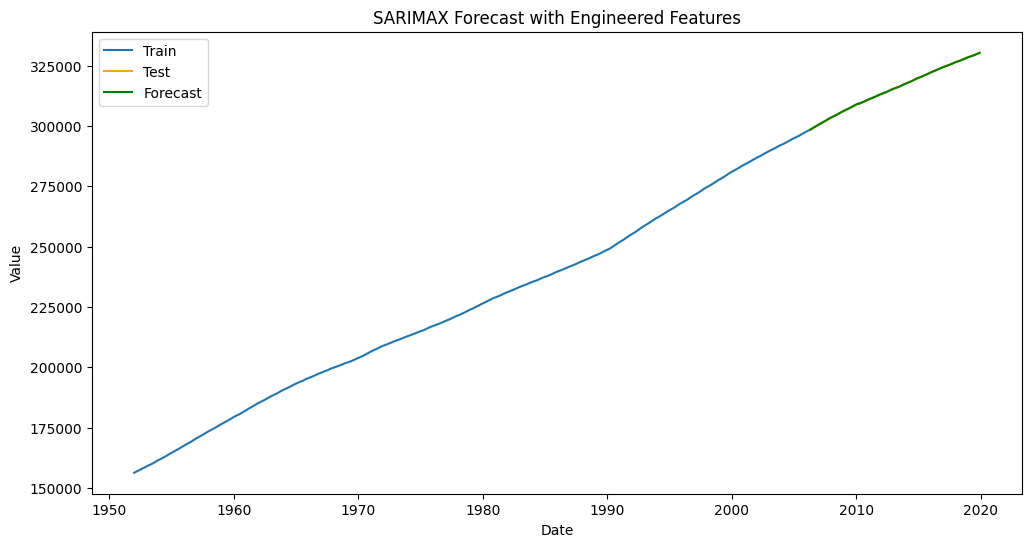

In [9]:
plt.figure(figsize=(12,6))
plt.plot(train['date'], train['value'], label='Train')
plt.plot(test['date'], test['value'], label='Test', color='orange')
plt.plot(test['date'], forecast, label='Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Forecast with Engineered Features')
plt.legend()
plt.show()

In [14]:
print(results.mle_retvals)


{'fopt': 2.729371255744601, 'gopt': array([-1.05791109e-04, -4.86144458e-07, -4.12292422e-07,  4.43310843e-02,
        9.15967759e-02, -1.09884327e-01, -7.32391925e-07,  0.00000000e+00,
        5.08871668e-01, -1.57912190e+00, -1.17429267e+00, -2.28119510e-01,
        5.87950366e-01, -1.04960132e+00,  1.05015948e-02, -1.93256972e-01,
       -3.05043738e-02,  9.79646269e-01, -3.74325011e-01,  4.22742268e-03,
       -2.00816133e-01, -9.89228399e-01, -8.56819546e-02,  1.09516003e+00,
        1.09915231e-01,  1.35263636e-01]), 'fcalls': 1485, 'warnflag': 1, 'converged': False, 'iterations': 50}


Optimization terminated successfully.
         Current function value: 3.816021
         Iterations: 3
         Function evaluations: 225

Convergence info: {'fopt': 3.8160213776940317, 'direc': array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.000000

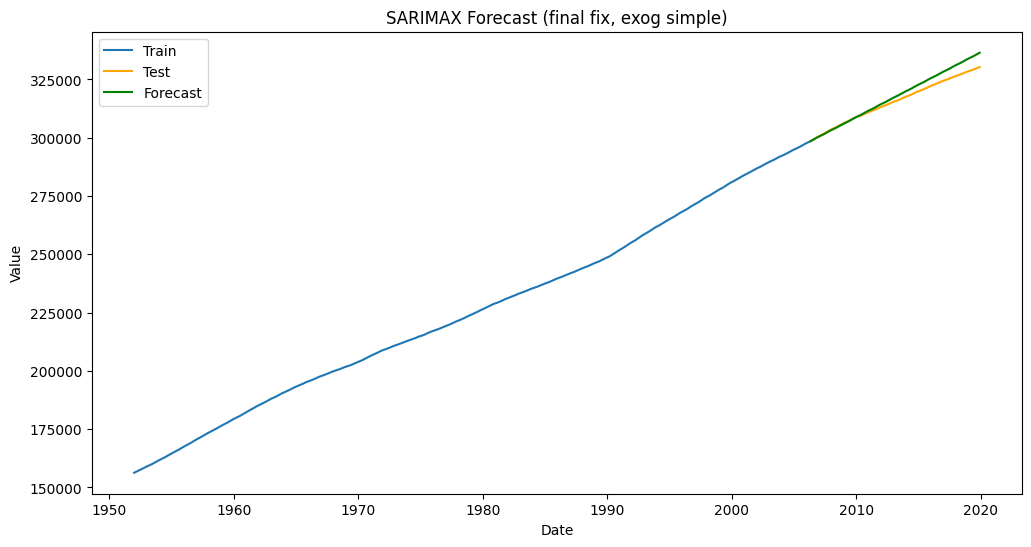

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === 1. Load data ===
df = pd.read_csv('POP.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# === 2. Feature engineering ===
def create_features(df):
    df = df.copy()
    df['year'] = df['date'].dt.year.astype(int)
    df['month'] = df['date'].dt.month.astype(int)
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    df['dayofweek'] = df['date'].dt.dayofweek.astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    # drop unused kolom
    df = df.drop(columns=['realtime_start', 'realtime_end'], errors='ignore')
    return df

df = create_features(df)

# === 3. Train/test split ===
train_size = int(len(df)*0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
exog_cols = ['year', 'month', 'weekofyear', 'dayofweek', 'is_month_start', 'is_month_end']

# === 4. Standarisasi exog ===
scaler = StandardScaler()
train_exog_scaled = scaler.fit_transform(train[exog_cols])
test_exog_scaled = scaler.transform(test[exog_cols])

# === 5. Fit SARIMAX ===
model = SARIMAX(
    train['value'],
    exog=train_exog_scaled,
    order=(1,1,0),                  # d=1 untuk differencing
    seasonal_order=(0,1,1,12),      # Seasonal MA(1)
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(method='powell', disp=True, maxiter=300)

print("\nConvergence info:", results.mle_retvals)

# === 6. Predict ===
forecast = results.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=test_exog_scaled
)

# === 7. Evaluate ===
mae = mean_absolute_error(test['value'], forecast)
rmse = np.sqrt(mean_squared_error(test['value'], forecast))
mape = np.mean(np.abs((test['value'] - forecast) / test['value'])) * 100
r2 = r2_score(test['value'], forecast)

print("\n====== Evaluation Metrics ======")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# === 8. Plot ===
plt.figure(figsize=(12,6))
plt.plot(train['date'], train['value'], label='Train')
plt.plot(test['date'], test['value'], label='Test', color='orange')
plt.plot(test['date'], forecast, label='Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Forecast (final fix, exog simple)')
plt.legend()
plt.show()


Optimization terminated successfully.
         Current function value: 3.778858
         Iterations: 9
         Function evaluations: 1036

Convergence info: {'fopt': 3.7788582564993316, 'direc': array([[-3.11512634e+05,  5.27771540e+03,  1.97103242e-01,
         9.34364226e-03,  0.00000000e+00,  0.00000000e+00,
         2.45246781e+04, -2.41380601e+05,  1.54989465e+05,
         0.00000000e+00,  0.00000000e+00, -7.71351130e-03,
        -1.02774873e-02, -1.55924874e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-9.76504788e+05,  5.09894594e+04, -8.04151492e-01,
         1.27664500e-01,  0.00000000e+00,  0.00000000e+00,
         1.30357719e+05, -1.72137769e+05, -2.58380902e+05,
         0.00000000e+00,  0.00000000e+00,  6.62593620e-03,
         4

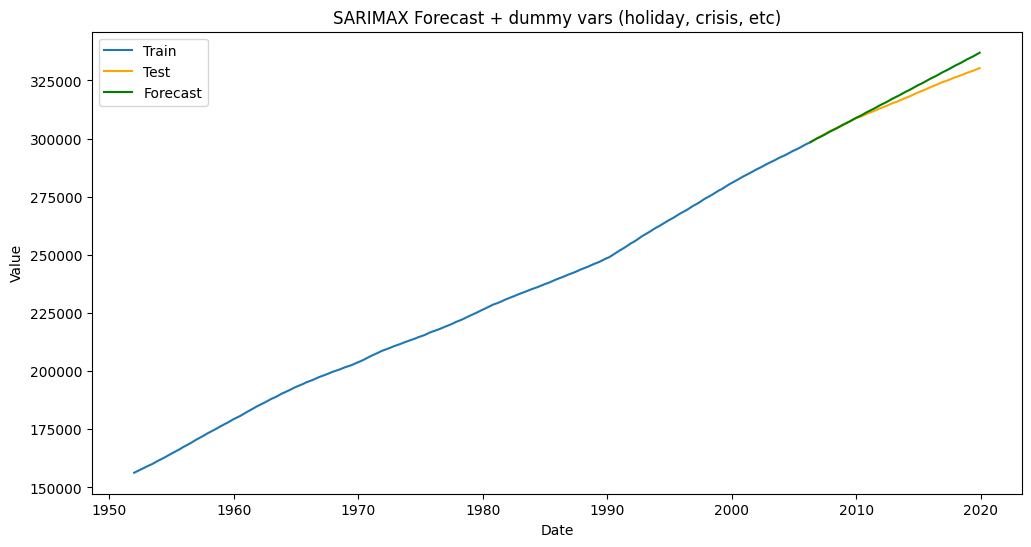

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === 1. Load data ===
df = pd.read_csv('POP.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# === 2. Feature engineering ===
df['year'] = df['date'].dt.year.astype(int)
df['month'] = df['date'].dt.month.astype(int)
df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
df['dayofweek'] = df['date'].dt.dayofweek.astype(int)
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

# Tambah dummy vars
df['is_newyear'] = (df['date'].dt.month == 1).astype(int)
df['is_december'] = (df['date'].dt.month == 12).astype(int)
df['is_q4'] = df['date'].dt.quarter.eq(4).astype(int)
df['after_2008'] = (df['date'].dt.year >= 2008).astype(int)
df['covid_period'] = ((df['date'] >= '2020-03-01') & (df['date'] <= '2021-12-31')).astype(int)

# === 3. Split ===
train_size = int(len(df)*0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

exog_cols = [
    'year', 'month', 'weekofyear', 'dayofweek', 'is_month_start', 'is_month_end',
    'is_newyear', 'is_december', 'is_q4', 'after_2008', 'covid_period'
]

# === 4. Standarisasi exog ===
scaler = StandardScaler()
train_exog = scaler.fit_transform(train[exog_cols])
test_exog = scaler.transform(test[exog_cols])

# === 5. Fit SARIMAX ===
model = SARIMAX(
    train['value'],
    exog=train_exog,
    order=(1,1,0),
    seasonal_order=(0,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(method='powell', disp=True, maxiter=300)

print("\nConvergence info:", results.mle_retvals)

# === 6. Predict ===
forecast = results.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=test_exog
)

# === 7. Evaluate ===
mae = mean_absolute_error(test['value'], forecast)
rmse = np.sqrt(mean_squared_error(test['value'], forecast))
mape = np.mean(np.abs((test['value'] - forecast) / test['value'])) * 100
r2 = r2_score(test['value'], forecast)

print("\n====== Evaluation Metrics ======")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# === 8. Plot ===
plt.figure(figsize=(12,6))
plt.plot(train['date'], train['value'], label='Train')
plt.plot(test['date'], test['value'], label='Test', color='orange')
plt.plot(test['date'], forecast, label='Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Forecast + dummy vars (holiday, crisis, etc)')
plt.legend()
plt.show()


C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_9140\1174436.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train = train_clean.groupby('month', group_keys=False).apply(lambda x: x.sample(n=min_count, replace=True)).reset_index(drop=True)


Optimization terminated successfully.
         Current function value: 1.592906
         Iterations: 3
         Function evaluations: 162

Convergence info: {'fopt': 1.5929061284970674, 'direc': array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.02867875,  0.        , -0.01040084, -0.00312163, -0.01610582,
        -0.0063673 ]]), 'iterations': 3, 'fcalls': 162, 'warnflag': 0, 'converged': True}

====== Evaluation Metrics ======
MAE: 69178.85
MAPE: 21.86%
RMSE: 70116.97
R²: -58.8867


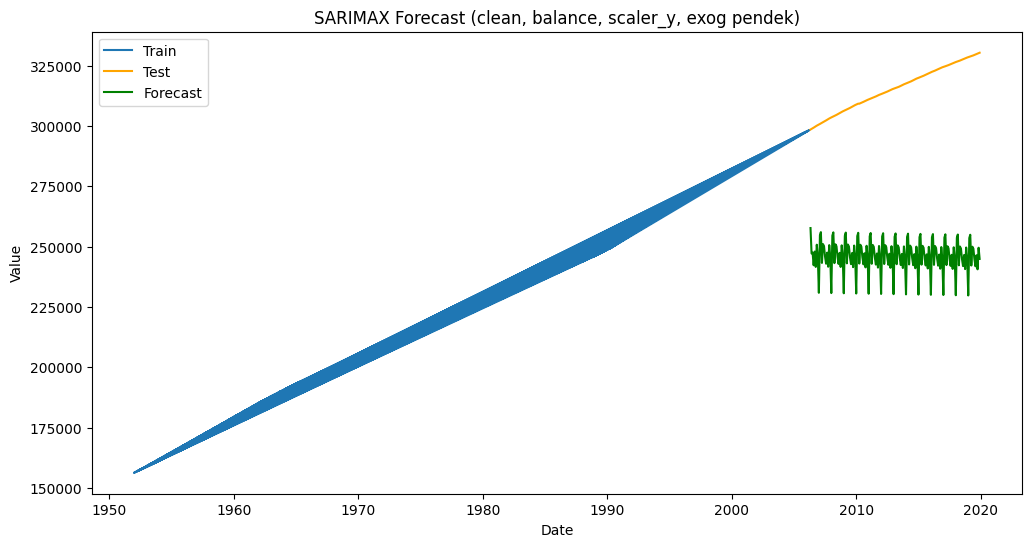

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === 1. Load data ===
df = pd.read_csv('POP.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# === 2. Feature engineering (exog pendek) ===
df['month'] = df['date'].dt.month.astype(int)
df['covid_period'] = ((df['date'] >= '2020-03-01') & (df['date'] <= '2021-12-31')).astype(int)
df['is_newyear'] = (df['date'].dt.month == 1).astype(int)
exog_cols = ['month', 'covid_period', 'is_newyear']

# === 3. Train/test split (aman, tanpa leakage) ===
train_size = int(len(df)*0.8)
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

# === 4. Delete outlier di train ===
Q1 = train['value'].quantile(0.25)
Q3 = train['value'].quantile(0.75)
IQR = Q3 - Q1
mask = (train['value'] >= Q1 - 1.5*IQR) & (train['value'] <= Q3 + 1.5*IQR)
train_clean = train.loc[mask].reset_index(drop=True)

# === 5. Balance train ===
min_count = train_clean['month'].value_counts().min()
balanced_train = train_clean.groupby('month', group_keys=False).apply(lambda x: x.sample(n=min_count, replace=True)).reset_index(drop=True)

# === 6. Standardize target & exog ===
scaler_y = StandardScaler()
train_y = scaler_y.fit_transform(balanced_train[['value']]).flatten()

scaler_x = StandardScaler()
train_exog = scaler_x.fit_transform(balanced_train[exog_cols])
test_exog = scaler_x.transform(test[exog_cols])

# === 7. Fit SARIMAX (simple & stabil) ===
model = SARIMAX(
    train_y,
    exog=train_exog,
    order=(1,1,0),
    seasonal_order=(0,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(method='powell', disp=True, maxiter=300)
print("\nConvergence info:", results.mle_retvals)

# === 8. Forecast & inverse transform ===
forecast_scaled = results.forecast(steps=len(test), exog=test_exog)
forecast = scaler_y.inverse_transform(forecast_scaled.reshape(-1,1)).flatten()

# === 9. Evaluate ===
mae = mean_absolute_error(test['value'], forecast)
rmse = np.sqrt(mean_squared_error(test['value'], forecast))
mape = np.mean(np.abs((test['value'] - forecast) / test['value'])) * 100
r2 = r2_score(test['value'], forecast)

print("\n====== Evaluation Metrics ======")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# === 10. Plot ===
plt.figure(figsize=(12,6))
plt.plot(balanced_train['date'], balanced_train['value'], label='Train')
plt.plot(test['date'], test['value'], label='Test', color='orange')
plt.plot(test['date'], forecast, label='Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Forecast (clean, balance, scaler_y, exog pendek)')
plt.legend()
plt.show()
